# STAT 201 Group 43 - Group Project Final Report

## Determining whether a mutant strain of the nematode *C. elegans* slows its speed when in the presence of nutrients

In [1]:
# Please run this cell before continuing, installing packages if necessary.
library(tidyverse)
library(RColorBrewer)
library(tidymodels)
set.seed(2023)
options(repr.plot.width = 10, repr.plot.height = 6)
library(infer) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.3     ✔ workflows    1.0.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.1     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

## 1. Introduction

### 1.1 Background

Parkinson’s disease (PD) is a neurodegenerative disease that is most commonly associated with motor deficiencies. The symptoms of PD are thought to be due in part to depletion of the transmission of a neurotransmitter called dopamine (DA) between neurons in the brain. However, the genetic aspects of PD are not well understood. Encouragingly, in recent years, genome-wide association studies (GWASs) have rapidly uncovered genes that may be associated with PD. In an effort to characterize these genes to determine whether they are truly relevant to the pathology of PD, the nematode (aka roundworm) *Caenorhabditis elegans* can be studied due to its expression of functionally equivalent (orthologous) genes of many PD-associated genes. *C. elegans* is a model organism that is often used for neurogenetics experiments due to its genome and neural connections both being completely mapped out (*C. elegans* Sequencing Consortium, 1998; White et al., 1986).

In this project, the effects of a mutation in the ortholog of a PD-associated gene, which renders the gene dysfunctional, will be examined.  Specifically, we will look at the effects on the basal slowing response (BSR), which is a dopamine-dependent slowing behaviour exhibited by *C. elegans* when in the presence of food (Sawin et al., 2000). A lack of slowing while on food indicates insufficient dopamine neurotransmission. CB1112 is the name of the mutant strain of *C. elegans* we will be using, as it is known to be deficient in dopamine.

### 1.2 Our question

Is there a difference in the mean speed of CB1112 *C. elegans* on food and CB1112 *C. elegans* not on food?

### 1.3 Our dataset 

The dataset being used was acquired using the Rankin Lab’s Multi-Worm Tracker (Swierczek et al., 2011), which allows for the tracking of *C. elegans* behaviour. The dataset contains measurements of many variables throughout a 420-second experiment in which many CB1112 *C. elegans* were allowed to crawl either in the presence of food or in the absence of food. These variables include many behavioural and morphological measures, but the main variable that will be focused on is the speed at which the worms were crawling throughout the experiment.

## 2. Methods and Results

### 2.1 Cleaning the Data

In [2]:
# Load the dataset
worm_data_raw <- read_csv('https://raw.githubusercontent.com/ben-westmore/stat-201-2022w2-group-43/main/N2_CB1112_baseline_output_12_11_2022.csv',
                          show_col_types = FALSE)

head(worm_data_raw)
nrow(worm_data_raw)

time_bin,worm,time,speed,x,y,angularspeed,pathlength,kink,bias,curve,dir,crab,length,midline,width,morphwidth,area,Strain
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
5,27,4.707,0.2312,23.73,29.97,10.880,0.07470,57.80,1,42.10,0,0.02003,0.7560,0.9690,0.2386,0.0867,0.0871,N2_Food
5,156,4.484,0.2195,36.94,25.75,7.300,0.13040,34.50,1,31.17,0,0.02087,0.9320,1.0360,0.1998,0.1648,0.1556,N2_Food
5,185,4.715,0.2563,25.62,24.98,34.660,0.08360,38.50,1,30.64,0,0.02118,0.7200,0.9310,0.2660,0.1404,0.1324,N2_Food
5,192,4.600,0.1354,28.47,19.23,5.484,0.06230,28.60,1,26.06,0,0.00981,0.5806,0.8200,0.1979,0.1378,0.1079,N2_Food
5,198,4.715,0.1797,24.28,30.77,3.680,0.05940,48.56,1,35.38,0,0.01484,0.7950,0.9263,0.1696,0.1467,0.1315,N2_Food
5,208,4.824,0.2135,27.83,25.23,5.035,0.05133,51.94,1,34.78,0,0.00853,0.8657,0.9717,0.2160,0.1774,0.1526,N2_Food


[1] 252756

The dataset contains information regarding each worm's strain, speed, time into the duration of the experiment (in seconds), position within the Multi-Worm Tracker's viewing frame, and various behavioural and morphological measures. In this project, we are only focusing on the speed of the CB1112 strain, so we select the following columns:

`Strain`: the type of mutation and whether they are on food.  
`Worm`: the ID of each worm.  
`Speed`: the speed of the worm (mm/s).

Some of the worms are recorded multiple times, so we group them by the worms’ ID (the `worm` column) and take the **mean** value of `speed` to calculate each individual worm’s speed.

In [3]:
# Select worm, speed, and Strain columns
# Filter observations with Strain "CB1112_Food" and "CB1112_NoFood"
# Calculate average speed of each worm

worm_data_cleaned <- worm_data_raw |>
    select(worm, speed, Strain) |>
    filter(Strain %in% c("CB1112_Food", "CB1112_NoFood")) |>
    group_by(Strain, worm) |>
    summarize(speed = mean(speed))

head(worm_data_cleaned)
nrow(worm_data_cleaned)

`summarise()` has grouped output by 'Strain'. You can override using the
`.groups` argument.


Strain,worm,speed
<chr>,<dbl>,<dbl>
CB1112_Food,1,0.2243345
CB1112_Food,2,0.1039276
CB1112_Food,3,0.1803790
CB1112_Food,4,0.2429433
CB1112_Food,6,0.2389154
CB1112_Food,7,0.1302114


[1] 932

Since we will only explore the speed of the **CB1112 strain**, we filter **“CB1112_Food"** and **"CB1112_NoFood”**, change their names to **“Food”** and **“NoFood”**, and rename the column `Strain` as `food_status`.

In [4]:
# Rename the column "Strain" as "food_status"
colnames(worm_data_cleaned)[1]  <- "food_status"

# Change "CB1112_Food" to "Food", "CB1112_NoFood" to "NoFood"
worm_data_cleaned$food_status[worm_data_cleaned$food_status=="CB1112_Food"] <- "Food"
worm_data_cleaned$food_status[worm_data_cleaned$food_status=="CB1112_NoFood"] <- "NoFood"

head(worm_data_cleaned)
nrow(worm_data_cleaned)

d1 <- worm_data_cleaned %>% filter(food_status == "Food")
nrow(d1)
d2 <- worm_data_cleaned %>% filter(food_status == "NoFood")
nrow(d2)

food_status,worm,speed
<chr>,<dbl>,<dbl>
Food,1,0.2243345
Food,2,0.1039276
Food,3,0.1803790
Food,4,0.2429433
Food,6,0.2389154
Food,7,0.1302114


[1] 932

[1] 521

[1] 411

The cleaned dataset contains a total of **932** observations, with **521** of them **on food** and **411** of them **not on food**.

### 2.2 Summary of Cleaned Dataset

#### Table 1. Summary Statistics Across *Food* and *NoFood* Groups

In [5]:
# Create Table 1
summary <- worm_data_cleaned |>
    group_by(food_status) |>
    summarize(mean = mean(speed),
              median = median(speed),
              sd = sd(speed),
              n = n())
summary

food_status,mean,median,sd,n
<chr>,<dbl>,<dbl>,<dbl>,<int>
Food,0.1799004,0.1842810,0.04499372,521
NoFood,0.2018251,0.2052696,0.04383005,411


### 2.3 Visualization of the Cleaned Dataset

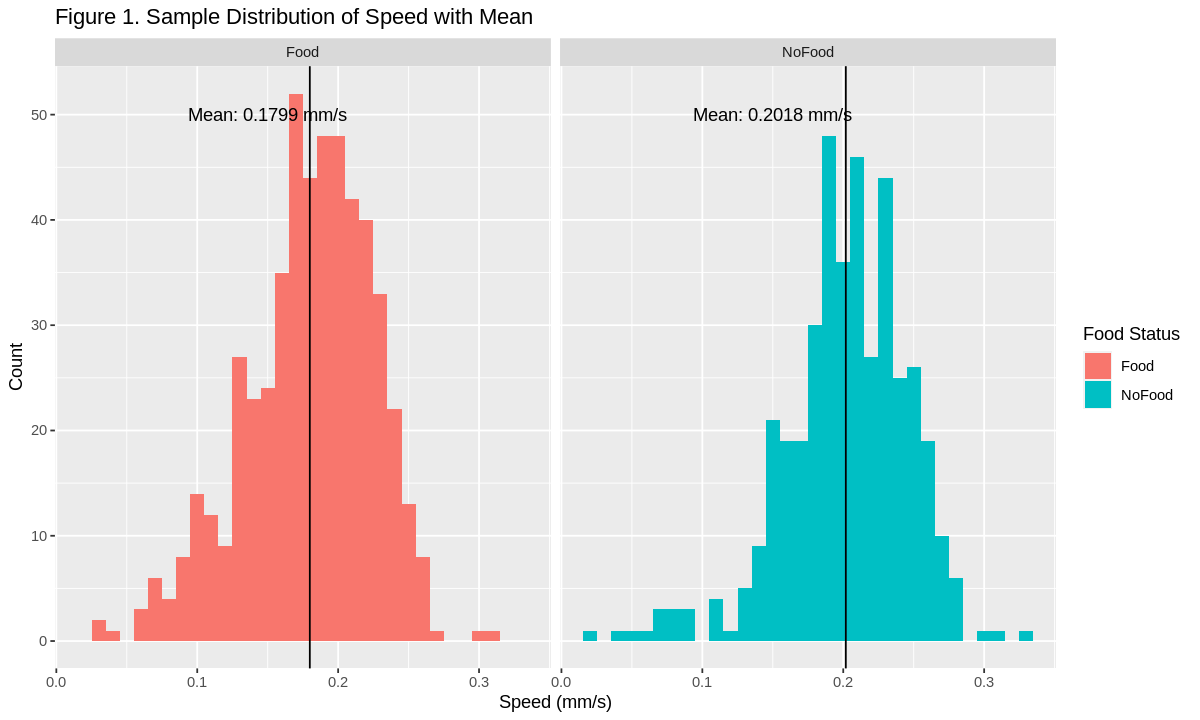

In [6]:
# Create histogram
hist <- worm_data_cleaned |>
    ggplot(aes(x = speed, fill = food_status)) +
    geom_histogram(binwidth = 0.01) +
    geom_vline(data = tibble(food_status = c("Food", "NoFood"), sample_mean = summary$mean), 
               aes(xintercept = sample_mean)) +
    geom_text(data = tibble(food_status = c("Food", "NoFood"), sample_mean=summary$mean),
              mapping = aes(x = 0.15, y = 50, label=paste("Mean:", round(sample_mean, 4), "mm/s"))) +
    facet_wrap(~food_status) +
    labs(x = "Speed (mm/s)",
         y = "Count",
         title = "Figure 1. Sample Distribution of Speed with Mean",
         fill = "Food Status")

hist

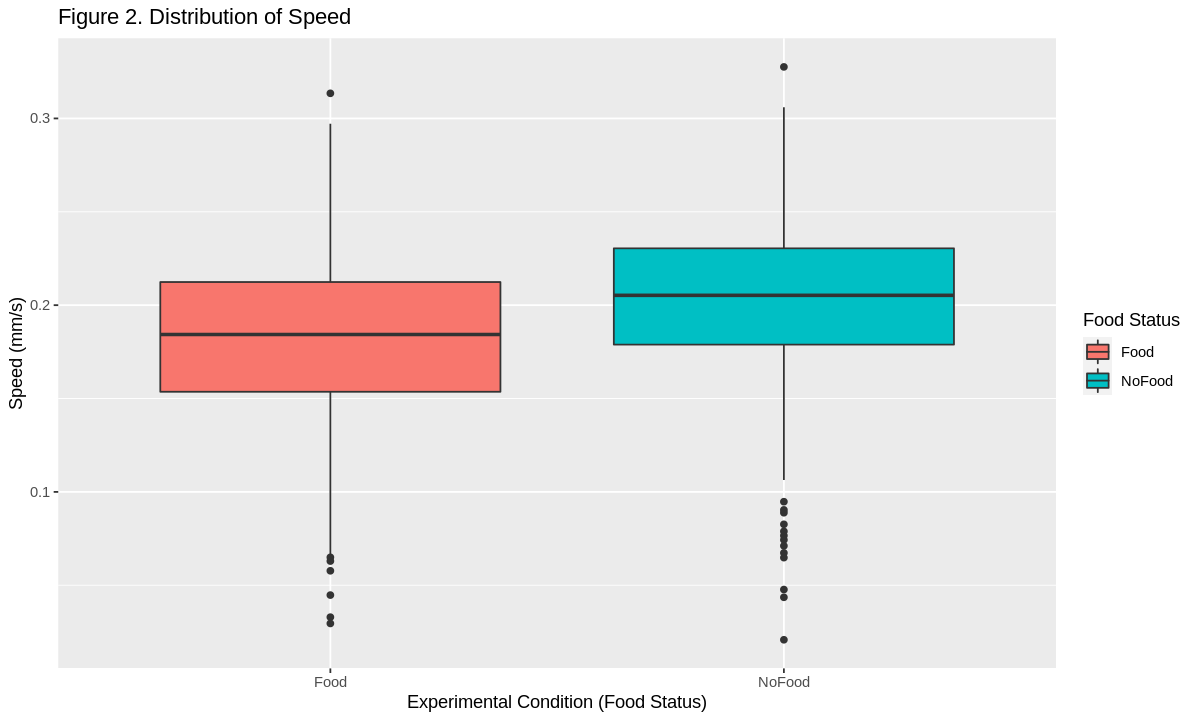

In [7]:
# Create boxplot
boxplot <- worm_data_cleaned |>
    ggplot() +
    geom_boxplot(aes(food_status, speed, fill = food_status)) +
    labs(x = "Experimental Condition (Food Status)",
         y = "Speed (mm/s)",
         title = "Figure 2. Distribution of Speed",
         fill = "Food Status")

boxplot

### 2.4 Hypothesis Tests

#### 2.4.1 Estimate of Parameter and Hypotheses

We specify the following notations for out hypothesis test:

$\bar{\mu}_0$: population mean speed of CB1112 *C. elegans* on food

$\bar{\mu}_1$: population mean speed of CB1112 *C. elegans* not on food

$\bar{x}_{1}$: sample mean speed of CB1112 *C. elegans* on food

$\bar{x}_{2}$: sample mean speed of CB1112 *C. elegans* not on food

Our null hypothesis is that the speed of CB1112 *C. elegans* on food and not on food is the same.  
Our alternative hypothesis is that the speed of CB1112 *C. elegans* on food and not on food is different.  
We denote them as:
$H_0$: $\bar{\mu}_0$ - $\bar{\mu}_1 = 0$ vs. $H_1$: $\bar{\mu}_0$ - $\bar{\mu}_1$ $\neq0$

We will conduct the hypothesis test using the **bootstrapping** method and **two-sample t-test** with **significance level $\alpha$ = 5%**

In [8]:
# Compute the observed test statistic
obs_mean_diff = summary$mean[1] - summary$mean[2]
obs_mean_diff

[1] -0.02192477

We will estimate the population difference in mean speeds $\bar{\mu}_0$ – $\bar{\mu}_1$ using $\bar{x}_{1}$ – $\bar{x}_{2} = -0.022$

#### 2.4.2 Bootstrapping

First, we use the `infer` package to bootstrap the **difference in mean speeds** between worms on food and not on food. 

`specify()`: We specify that the **response variable** is `speed` and the **explanatory variable** is `food_status`.  
`hypothesize()`: We set our **null hypothesis** to be that `speed` and `food_status` are **independent**.  
`generate()`: We generate 3000 **replicates** with the same size as our original dataset using **bootstrapping** method.  
`calculate()`: the population parameter we want to estimate is the difference in **mean** `speed`.


In [9]:
set.seed(2023)

bootstrapping_model <- 
    worm_data_cleaned |>
    specify(formula = speed ~ food_status) |> 
    hypothesize(null = "independence") |> 
    generate(reps = 3000, type = "bootstrap") |>
    calculate(stat="diff in means", order = c("Food", "NoFood"))

head(bootstrapping_model)

replicate,stat
<int>,<dbl>
1,-0.01885838
2,-0.02004434
3,-0.01816778
4,-0.02241108
5,-0.02170621
6,-0.01950604


Next, we obtain the 95% confidence interval for the bootstrapping distribution.


#### Table 2. 95% Confidence Interval for Boostrapping Distribution

In [10]:
# Compute 95% Confidence Interval
ci <- 
    bootstrapping_model %>% 
    summarize(ci_lower = quantile(stat, 0.025),
              ci_upper = quantile(stat, 0.975))
ci

ci_lower,ci_upper
<dbl>,<dbl>
-0.02767133,-0.01626572


The result shows that we are **95%** confident that the **true difference in mean speeds** is between **0.016mm/s** and **0.028mm/s**.

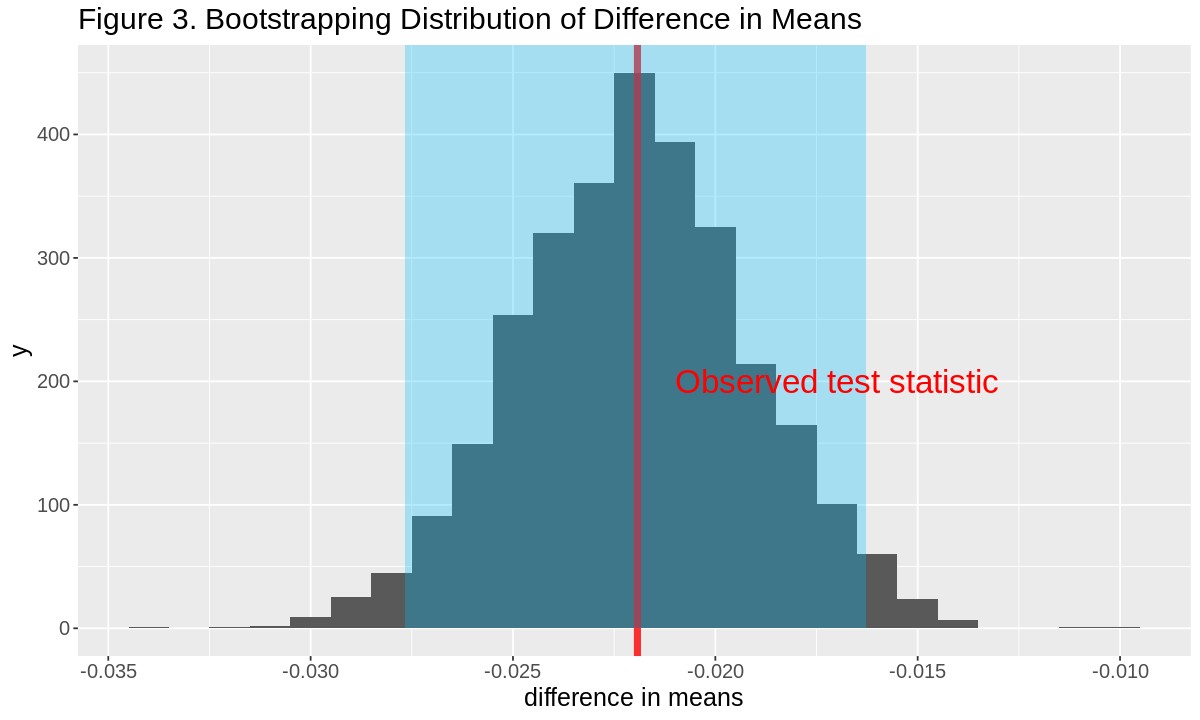

In [11]:
# Visualize the 95% confidence interval and the observed test statistic on the bootsrapping distribution
bootstrapping_dist <- bootstrapping_model |>
     ggplot() + 
     geom_histogram(aes(x=stat), binwidth = 0.001) +
     geom_vline(xintercept = obs_mean_diff, color = "red", alpha = .8, lwd=2) + 
     xlab("difference in means") + 
     annotate("rect", xmin = ci$ci_lower, xmax = ci$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
     theme(text = element_text(size=15)) + 
     ggtitle("Figure 3. Bootstrapping Distribution of Difference in Means") +
     annotate("text", x = -0.017, y = 200, label = "Observed test statistic", color = "red", size=7)

bootstrapping_dist

Then, we shift the `bootstrapping_model` to have it centred at **0** to create the `null_model`.

In [12]:
# Generate the null model
null_model <- bootstrapping_model |>
mutate(stat = stat + (0 - obs_mean_diff))

head(null_model)

replicate,stat
<int>,<dbl>
1,0.0030663868
2,0.0018804315
3,0.0037569912
4,-0.0004863147
5,0.0002185620
6,0.0024187279


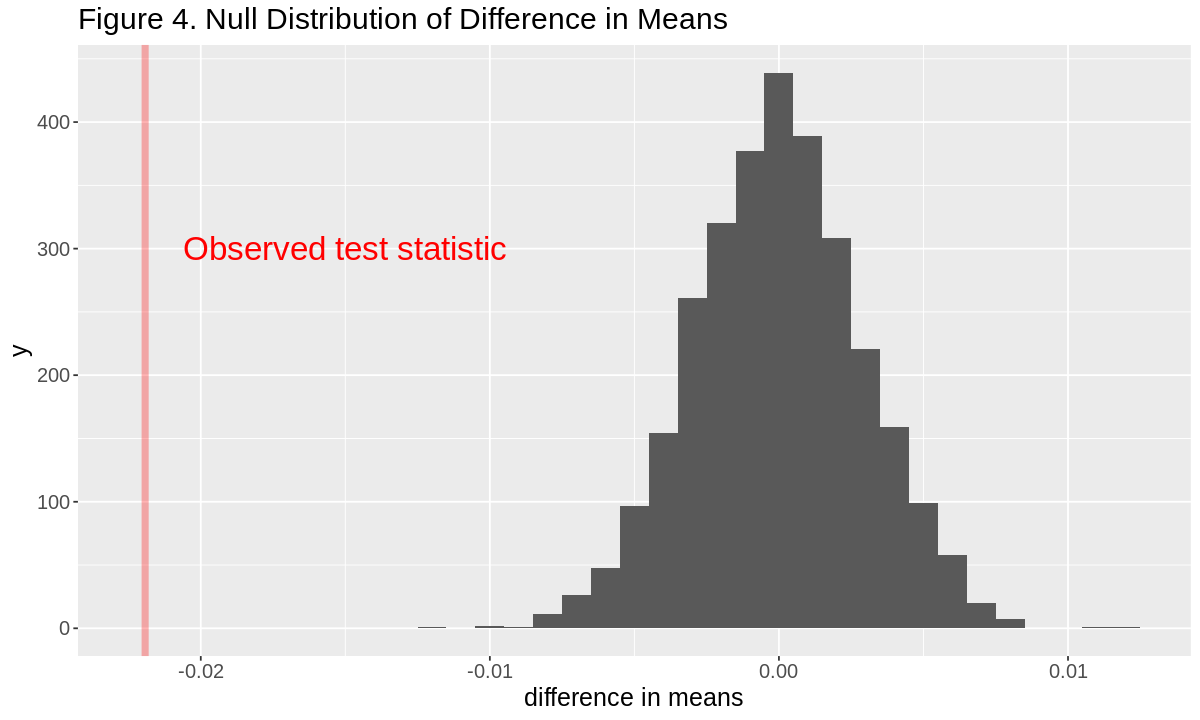

In [13]:
# Visualize the observed test statistic on the null distribution

null_dist <- null_model |>
     ggplot() + 
     geom_histogram(aes(x=stat), binwidth = 0.001) +
     geom_vline(xintercept = obs_mean_diff, color = "red", alpha=.3, lwd=2) + 
     xlab("difference in means") + 
     theme(text = element_text(size=15)) + 
     ggtitle("Figure 4. Null Distribution of Difference in Means") +
     annotate("text", x = -0.015, y = 300, label = "Observed test statistic", color="red", size=7)

null_dist

The visualization shows that our observed test statistic ($\bar{x}_{1}$ – $\bar{x}_{2} = -0.022$) falls at the **left extreme** of the null model, which indicates that the true difference in mean speeds between CB1112 *C. elegans* on food and not on food is **unlikely to be 0**.

Next, we obtain the p-value and compare it to the 5% significance level.

In [14]:
# Calculate p-value

p_val <- 
    null_model%>% 
    get_p_value(obs_stat = obs_mean_diff, direction = "two.sided")

p_val

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


The p-value (which is rounded down to 0) is **much smaller** than the 5% significance level. Therefore, there is not sufficient evidence to support that the mean speed of CB1112 *C. elegans* on food and not on food is the same, and we **reject $H_0$**.

However, it is rare to obtain a p-value this close to 0. One possible explanation for it is that, due to the **large size** of our original data (521 for on food group and 411 for not on food group), the bootstrapped estimates are likely to have **less variability** and **a narrower spread**. The narrower spread makes our observed difference in mean speed extremely **outstanding** and results in a p-value close to 0.

Now we can bootstrap the Food sample and NoFood sample separately to verify the result we obtained above.

`specify()`: We specify that the **response variable** is `speed`.  
`generate()`: We generate 3000 **replicates** with the same size as our original dataset.  
`calculate()`: We choose **mean** `speed` as the parameter we want to estimate.

In [15]:
# set seed
set.seed(2023)

# extract bootstrap distribution of worms on food and calculate the mean
onfood_bootstrap <- worm_data_cleaned |>
                filter(food_status == "Food") |>
                specify(response = speed) %>% 
                generate(type = "bootstrap", reps = 3000) %>% 
                calculate(stat = "mean")

# extract bootstrap distribution of worms not on food and calculate the mean
nofood_bootstrap <- worm_data_cleaned |>
                filter(food_status == "NoFood") |>
                specify(response = speed) %>% 
                generate(type = "bootstrap", reps = 3000) %>% 
                calculate(stat = "mean")

# display the head of data of bootstrap distribution of worms on food
head(onfood_bootstrap)

# display the head of data of bootstrap distribution of worms not on food
head(nofood_bootstrap)

replicate,stat
<int>,<dbl>
1,0.1804774
2,0.1839276
3,0.1819045
4,0.1805449
5,0.1813922
6,0.1813035


replicate,stat
<int>,<dbl>
1,0.2036373
2,0.1989341
3,0.2041286
4,0.2011692
5,0.2004116
6,0.2005447


Then, we obtain the 95% confidence interval for the two bootstrapping distributions.

#### Table 3. 95% Confidence Interval for Bootstrapping Distribution of Worms on Food

In [16]:
# Compute 95% Confidence Interval for Worms on Food
ci_food <- 
    onfood_bootstrap %>% 
    summarize(ci_lower = quantile(stat, 0.025),
              ci_upper = quantile(stat, 0.975))
ci_food 

ci_lower,ci_upper
<dbl>,<dbl>
0.1758642,0.1836436


#### Table 4. 95% Confidence Interval for Bootstrapping Distribution of Worms not on Food

In [17]:
# Compute 95% Confidence Interval for Worms not on Food
ci_nofood <- 
    nofood_bootstrap %>% 
    summarize(ci_lower = quantile(stat, 0.025),
              ci_upper = quantile(stat, 0.975))
ci_nofood 

ci_lower,ci_upper
<dbl>,<dbl>
0.1976185,0.2061273


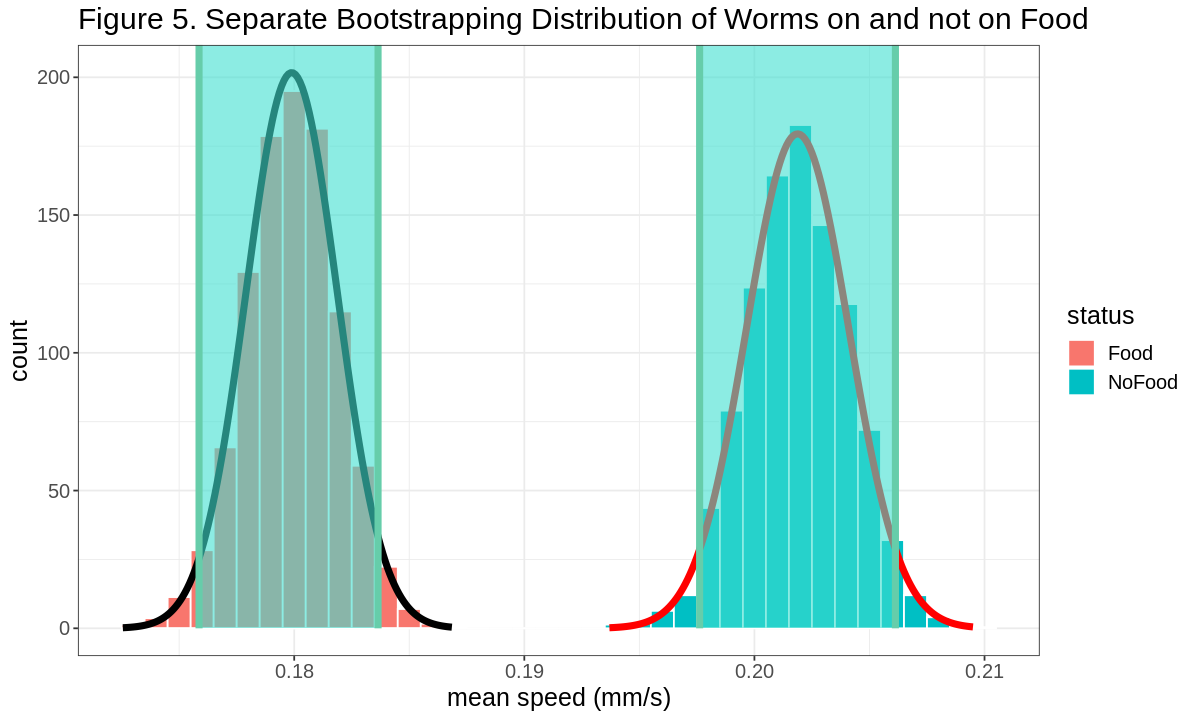

In [18]:
# combine data from the two bootstrap distributions
all_bootstrap <- bind_rows(onfood_bootstrap |> mutate(status = "Food"), nofood_bootstrap |> mutate(status = "NoFood"))

# visualize the bootstrapping data by histogram
bootstrap_dist <- all_bootstrap |>
                    group_by(replicate, status) |>
                    ggplot() +
                    geom_histogram(aes(x = stat, y = ..density.., fill = status), color = "white", binwidth = 0.001) +
                    geom_line(data = tibble(mean = seq(min(onfood_bootstrap$stat), max(onfood_bootstrap$stat), 0.0001),
                                           density = dnorm(mean, mean(onfood_bootstrap$stat), sd(onfood_bootstrap$stat))),
                             aes(x = mean,
                                 y = density),
                             color = "black", lwd = 2) +
                    geom_line(data = tibble(mean = seq(min(nofood_bootstrap$stat), max(nofood_bootstrap$stat), 0.0001),
                                           density = dnorm(mean, mean(nofood_bootstrap$stat), sd(nofood_bootstrap$stat))),
                             aes(x = mean,
                                 y = density),
                             color = "red", lwd = 2) +

                    shade_confidence_interval(endpoints = ci_food)+
                    shade_confidence_interval(endpoints = ci_nofood)+
                    xlab("mean speed (mm/s)") +
                    ylab("count") +
                    theme_bw() +
                    theme(text = element_text(size = 15)) +
ggtitle("Figure 5. Separate Bootstrapping Distribution of Worms on and not on Food")

bootstrap_dist

Based on the separate bootstrapping distribution, there is **no overlap between the two distributions**, which indicates that the population means for speed are not likely to be equal, and it confirms our conclusion of **rejecting $H_0$**.

### 2.4.3 Two-Sample t-Test

Next, we will conduct a two-sample t-test using the `t.test` function from the `tidy` package.

`x`: data of worms on food.  
`y`: data of worms not on food.  
`conf.level`: we use a 95% confidence interval.   
`alternative`: since our alternative hypothesis is “not equal”, this is a “two.sided” test.


In [19]:
# two-sample t-test between mean speed of worms on food and worms not on food

# get data for worms on food
on_food <- worm_data_cleaned |>
            filter(food_status == "Food") |>
            select(speed) |>
            pull()

# get data for worms not on food
no_food <- worm_data_cleaned |>
            filter(food_status == "NoFood") |>
            select(speed) |>
            pull()

head(on_food)
head(no_food)

Adding missing grouping variables: `food_status`
Adding missing grouping variables: `food_status`


[1] 0.2243345 0.1039276 0.1803790 0.2429433 0.2389154 0.1302114

[1] 0.1927800 0.2410008 0.1792456 0.2061022 0.1987700 0.2407833

#### Table 5. Summary of Two-Sample t-Test

In [20]:
# compute two-sample t-test of worms on food and not on food and calculate confidence interval at 95%
worm_t_test <- 
    tidy(
        t.test(x = on_food,
               y = no_food,
               conf.level = 0.95,
               alternative = "two.sided"))

# display the result
worm_t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-0.02192477,0.1799004,0.2018251,-7.493812,1.613854e-13,890.0431,-0.02766687,-0.01618266,Welch Two Sample t-test,two.sided


The p-value of $1.61 \times 10^{-13}$ is much **smaller** than the 5% significance level, so there is not sufficient evidence to support that the population mean speed of worms on food and not on food is the same. Therefore, we **reject $H_0$**.

### 2.4.4 CLT and Confidence Interval 

There are three conditions that are needed to utilize the Central Limit Theorem method:
* All the samples taken should be independent from the population.
* To achieve independence of the sample’s variables, the sample size must be less than 10% of the population size.
* Sample size must be large enough (at least 30) to be representative of the whole population.

Since we have met all three conditions above, we can now compute the 95% confidence interval for the mean speed for CB1112 *C. elegans* with food and without food. We assign them to `clt_onfood_ci` and `clt_nofood_ci`

In [21]:
set.seed(50)

# We get sample for onfood worms and nofood worms respectively
sample_onfood <- worm_data_cleaned %>%
    filter(food_status == "Food") %>%
    rep_sample_n(size = 300, replace = F)

sample_nofood <- worm_data_cleaned %>%
    filter(food_status == "NoFood") %>%
    rep_sample_n(size = 300, replace = F)

# We compute the mean and standard error for each sample
onfood_sum <- sample_onfood %>%
    summarise(mean = mean(speed),
              se = sd(speed)/sqrt(nrow(sample_onfood)))

nofood_sum <- sample_nofood %>%
    summarise(mean = mean(speed),
              se = sd(speed)/sqrt(nrow(sample_nofood)))

#### Table 6. 95% Confidence Interval for Worms not on Food Using CLT

In [22]:
# We obtain the 95% confidence interval using CLT 
clt_onfood_ci <- 
    tibble(
        lower_ci = qnorm(0.025, mean = onfood_sum$mean, sd = onfood_sum$se),
        upper_ci = qnorm(0.975, mean = onfood_sum$mean, sd = onfood_sum$se))
clt_onfood_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.1763886,0.1866804


#### Table 7. 95% Confidence Interval for Worms on Food Using CLT

In [23]:
clt_nofood_ci <- 
    tibble(
        lower_ci = qnorm(0.025, mean = nofood_sum$mean, sd = nofood_sum$se),
        upper_ci = qnorm(0.975, mean = nofood_sum$mean, sd = nofood_sum$se))
clt_nofood_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.1965121,0.2062053


We can interpret the two confidence intervals above as: 
* We are 95% confident that the mean speed of CB1112 *C. elegans* with food is between 0.1763886 mm/s and 0.1866804 mm/s.
* We are 95% confident that the mean speed of CB1112 *C. elegans* without food is between 0.1965121 mm/s and 0.2062053 mm/s.

### 2.4.5 Comparing Bootstrapping to CLT

Below shows the visualization of the bootstrap sampling distribution and Normal density given by CLT.

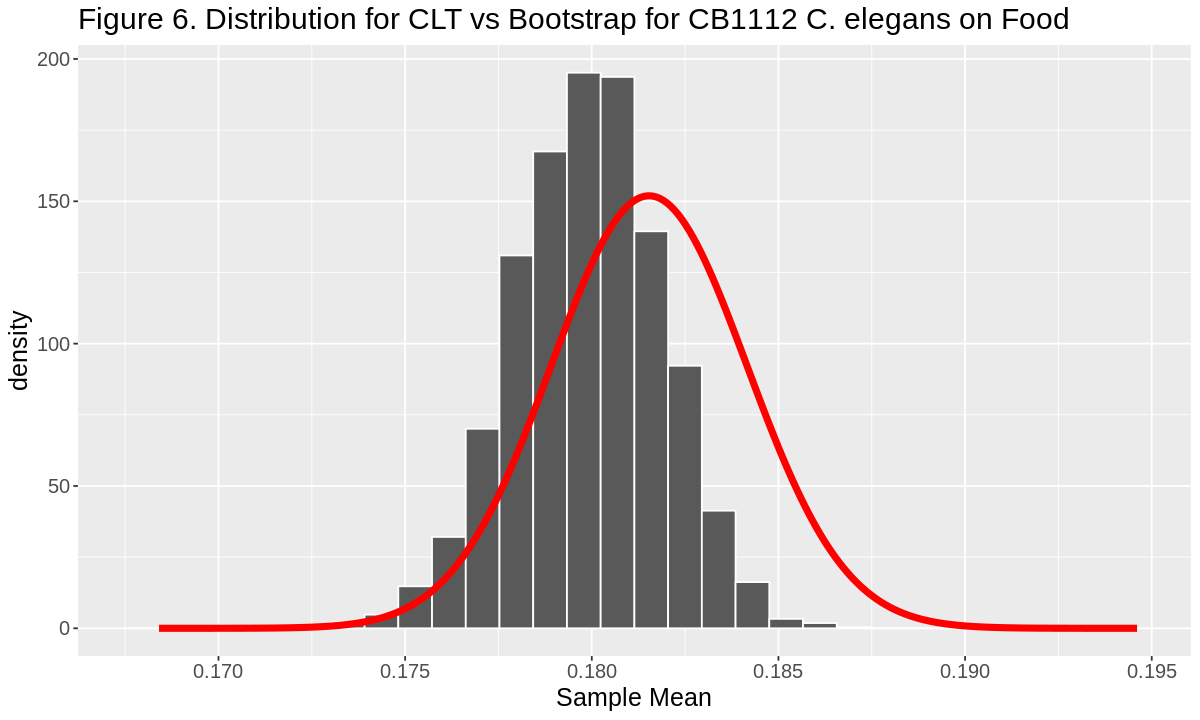

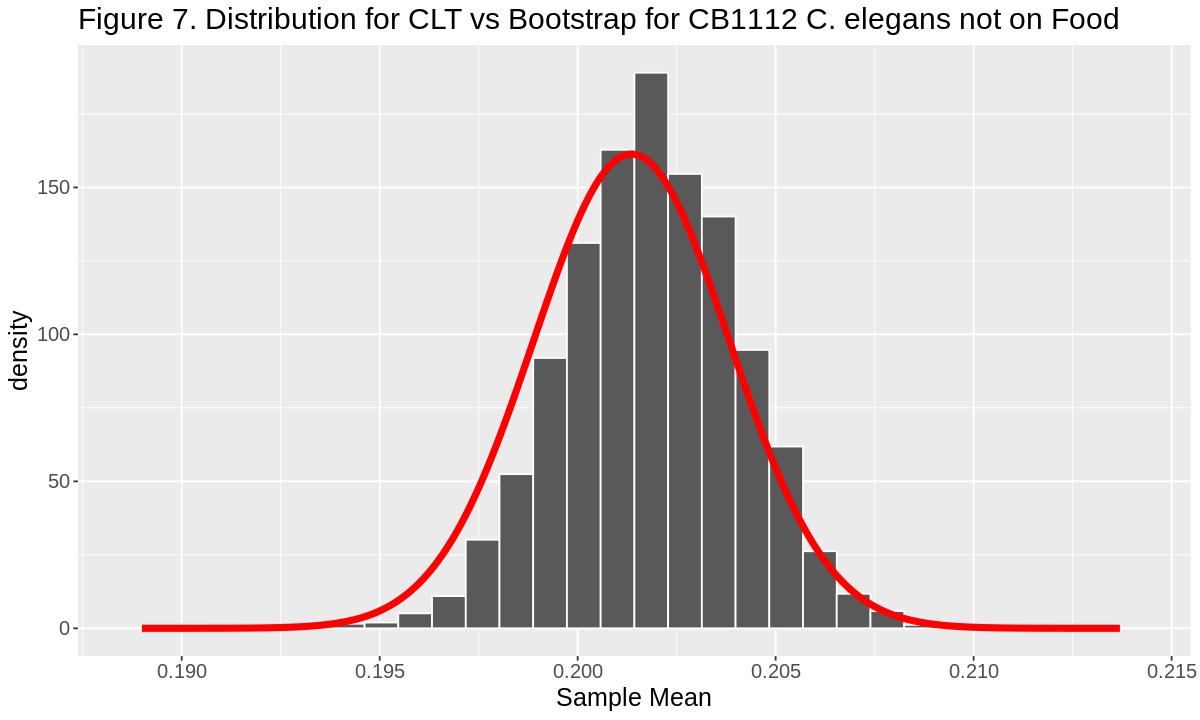

In [24]:
# Obtain sample mean for on_food worms and no_food worms
onfood_x_bar <- onfood_sum$mean
nofood_x_bar <- nofood_sum$mean

# Obtain the sample std error for on_food worms and no_food worms
onfood_std_error <- onfood_sum$se
nofood_std_error <- nofood_sum$se

# Get the normal curve
onfood_clt_samp_dist <- 
    tibble(x = seq(onfood_x_bar - 5 * onfood_std_error, 
                   onfood_x_bar + 5 * onfood_std_error, 0.0001),
           density = dnorm(x, onfood_x_bar, onfood_std_error))

nofood_clt_samp_dist <- 
    tibble(x = seq(nofood_x_bar - 5 * nofood_std_error, 
                   nofood_x_bar + 5 * nofood_std_error, 0.0001),
           density = dnorm(x, nofood_x_bar, nofood_std_error))

# Then we plot the bootstrap vs the CLT estimates
onfood_btsp_vs_clt_samp_dist_plot <- 
    onfood_bootstrap %>% 
    ggplot() + 
    geom_histogram(aes(stat, ..density..), bins = 30, color = 'white') + 
    geom_line(data = onfood_clt_samp_dist, aes(x, density), lwd = 2, color = "red") + 
    xlab("Sample Mean") + 
    ggtitle("Figure 6. Distribution for CLT vs Bootstrap for CB1112 C. elegans on Food") + 
    theme(text = element_text(size = 15))

nofood_btsp_vs_clt_samp_dist_plot <- 
    nofood_bootstrap %>% 
    ggplot() + 
    geom_histogram(aes(stat, ..density..), bins = 30, color = 'white') + 
    geom_line(data = nofood_clt_samp_dist, aes(x, density), lwd = 2, color = "red") + 
    xlab("Sample Mean") + 
    ggtitle("Figure 7. Distribution for CLT vs Bootstrap for CB1112 C. elegans not on Food") + 
    theme(text = element_text(size = 15))

onfood_btsp_vs_clt_samp_dist_plot
nofood_btsp_vs_clt_samp_dist_plot

### 2.5 Bootstrapping vs. Asymptotics

We used both the Asymptotic method (CLT in our case), and bootstrapping in our analysis because our dataset satisfied both requirements:
* We have over 900 datapoints that contain almost all possible cases, so we treated this dataset as a population.
* The population has an approximately normal distribution.
* We used both bootstrapping and CLT methods to estimate the sample mean, in order to compare the confidence intervals.
* The confidence interval is useful to measure the precision of our estimates.

The large sample size made it so that both bootstrapping and using the CLT generated similar distributions with approximately normalized shape. Let's take a look at the relationship of food status and the speed of CB1112 *C. elegans*. Since the bootstrap distribution is conducted through 3000 randomly selected samples, there is no guarantee that all the points selected are from the center (near the median of the two sample groups). On top of that, we observed a difference between the CLT distribution and the bootstrap distribution. Because most of the population is centralized around 0.18 and 0.202, this leads to the fact that when we draw a sample, we are likely to extract data points in the middle. However, when we draw for bootstrapping, with randomly selected samples, the probability of selecting data points in the middle or on both sides of the population (replacement = True) varies. In conclusion, it is not a surprise that we discovered a slight difference between bootstrapping and the CLT.

Both bootstrapping and CLT are very reliable, as they can handle different scenarios. In our case, since our data satisfied both bootstrapping and CLT’s conditions, we cannot say which method is better. Bootstrapping is a great method to use when people do not have the population standard deviation, as it requires a normalized sample distribution. CLT on the other hand requires a population standard deviation, but can still discover the sample mean even if the population distribution is not normalized. Both methods support us in determining the confidence level of our estimates, therefore we used both methods to ensure accuracy.

## 3. Discussion

**3.1 What we found:**
- The observed difference in mean speeds between CB1112 *C. elegans* in the two conditions was found to be approximately 0.022 mm/s.
- When hypothesis tests were conducted using both the bootstrapping method and the asymptotics method, it was found that there was a significant difference between the average speeds of the CB1112 *C. elegans* in the two conditions, with p < 0.01 (much smaller than our 5% significance level).
- Based on these findings, we have gathered evidence to support the idea that dopamine-deficient CB1112 *C. elegans* do exhibit a significant slowing response when in the presence of nutrients. Therefore, we should reject the null hypothesis which posits that there is no difference in the average speed of CB1112 *C. elegans* in the presence of nutrients and CB1112 *C. elegans* in the absence of nutrients.
- Some **implications** of these findings are that:
    - Although CB1112 *C. elegans* are known to be dopamine-deficient, and the basal slowing response is known to be a dopamine-mediated behaviour, CB1112 *C. elegans* still slow in the presence of nutrients.
    - There may be something other than dopamine-deficiency at play in the slowing response of the worms included in our data set.
- Potential **impact** these findings may have:
    - Factors other than dopamine may need to be considered when predicting whether a certain mutant strain of *C. elegans* will exhibit a basal slowing response when in the presence of nutrients.
    
**3.2 Did these results match our expectations?**  
As was previously discussed in the introduction, a lack of slowing while on food indicates insufficient dopamine neurotransmission. Seeing as CB1112 is a strain of *C. elegans* that is known to be deficient in dopamine, it would be expected that they would not exhibit a slowing response when in the presence of nutrients due to the fact that the basal slowing response is a dopamine-mediated behaviour. However, based on the data used for our analysis, we were able to conclude that there *is* a significant difference in the average speeds of CB1112 *C. elegans* in the presence of nutrients compared to the average speed of CB1112 *C. elegans* in the absence of nutrients. Therefore, **our results were not what we expected to find**.

**3.3 Future questions this study could lead to:**  
- What might be causing the dopamine-deficient CB1112 *C. elegans* to slow in the presence of nutrients, considering the fact that the basal slowing response is known to be a behaviour mediated by dopamine?
- Is there another mechanism that doesn’t involve dopamine that causes dopamine-deficient *C. elegans* strains such as CB1112 to slow when in the presence of nutrients?

**3.3 Future research this study could lead to:**  
- Attempt to replicate the study from which the data set used for this project was obtained in order to identify whether the difference in average speeds between conditions persists.
- Very diligent efforts could be made to investigate whether there are any other variables that are causing there to be a difference in average speeds between conditions.

## References

C. elegans Sequencing Consortium. (1998). Genome Sequence of the Nematode C. elegans: A Platform for Investigating Biology. Science, 282(5396), 2012–2018. https://doi.org/10.1126/science.282.5396.2012

Sawin, E. R., Ranganathan, R., & Horvitz, H. R. (2000). C. elegans locomotory rate is modulated by the environment through a dopaminergic pathway and by experience through a serotonergic pathway. Neuron, 26(3), 619–631. https://doi.org/10.1016/s0896-6273(00)81199-x

Swierczek, N. A., Giles, A. C., Rankin, C. H., & Kerr, R. A. (2011). High-throughput behavioral analysis in C. elegans. Nature Methods, 8(7), 592–598. https://doi.org/10.1038/nmeth.1625

White, J. G., Southgate, E., Thomson, J. N., & Brenner, S. (1986). The structure of the nervous system of the nematode Caenorhabditis elegans. Philosophical Transactions of the Royal Society of London. Series B, Biological Sciences, 314(1165), 1–340. https://doi.org/10.1098/rstb.1986.0056